In [1]:

import json
import yaml

    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp
        
sensor_log,first_timestamp=load_sensor_log_file("../to_study/caterpillar_test.txt")

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader,TensorDataset,random_split
from torch.utils.data.sampler import SubsetRandomSampler

#get the data and turn it into a state vector

#Full State Vector Design
#Position:  Value
#     0  -  x gyro velocity
#     1  -  y gyro velocity
#     2  -  z gyro velocity
#     3  -  x acceleration
#     4  -  y acceleration
#     5  -  z acceleration
#     6 -   x B field
#     7 -   y B field
#     8 -   z B field
#     9 -  left motor active
#    10 -  right motor active
#    11 -  visual odotometer speed  
#    12 -  left motor command
#    13 -  right motor command

#Command Vector Design
# 0 left motor command
# 1 right motor command
state_to_command_mapping=[12,13]

#Things to predict
# visual odometer speed
# z gyro velocity
# x acceleration
# y acceleration
state_to_predict_mapping=[11,2,3,4]

state_names=["gyro_x","gyro_y","gyro_z","accel_x","accel_y","accel_z","B_x","B_y","B_z","left_motor_active","right_motor_active","vodometer","left_motor_command","right_motor_command"]

state_vector_length=14
command_vector_length=len(state_to_command_mapping)
predict_vector_length=len(state_to_predict_mapping)

def parse_message_list_to_state_vectors(message_list):
    
    
    
    gyro_scale=1
    gyro_clip_value=10
    b_field_scale=50
    b_field_clip_value=100
    accel_scale=4
    #accel_scale=1
    accel_clip_value=20
    drive_scale=1
    drive_clip_value=10   
    video_offset_scale=1000    
    ret_state=[]
    ret_command=[]
    ret_predict=[]
    
    on_state_vector=np.zeros(state_vector_length)    
    

    state_vector_avg_count=np.zeros(state_vector_length)
    
    last_timestep=0
    time_spacing=0.1
    start_timestamp=message_list[0]["timestamp"]
    for message in message_list:
        t=message["timestamp"]-start_timestamp
        #print("t= {}, state vec is {}".format(t,on_state_vector[11]))
        #if we've crossed a boundary do averages
        if t-last_timestep>time_spacing:
            last_timestep+=time_spacing
            avg_vector=torch.zeros(state_vector_length)
            for i in range(state_vector_length):
                if state_vector_avg_count[i]!=0:
                    avg_vector[i]=on_state_vector[i]/state_vector_avg_count[i]
                else:
                    avg_vector[i]=on_state_vector[i]
            
            on_command_vector=torch.zeros(command_vector_length)
            on_predict_vector=torch.zeros(predict_vector_length)        
            for i in range(len(state_to_command_mapping)):
                on_command_vector[i]=avg_vector[state_to_command_mapping[i]]
            for i in range(len(state_to_predict_mapping)):
                on_predict_vector[i]=avg_vector[state_to_predict_mapping[i]]
            
            #print("saving {}".format(avg_vector[11]))
            ret_state.append(avg_vector)
            ret_predict.append(on_predict_vector)
            ret_command.append(on_command_vector)
            
            
            on_state_vector=np.zeros(state_vector_length)    
            state_vector_avg_count=np.zeros(state_vector_length)
            #print("resetting")
        
        
        
        if "position_sensor/gyro" in message:
            m=message["position_sensor/gyro"]
            for i in range(3):
                if m[i] is not None and m[i]<gyro_clip_value and m[i]>-gyro_clip_value:
                    on_state_vector[0+i]+=m[i]/gyro_scale
                    state_vector_avg_count[0+i]+=1
        if "position_sensor/b_field" in message:
            m=message["position_sensor/b_field"]
            for i in range(3):
                if m[i] is not None and m[i]<b_field_clip_value and m[i]>-b_field_clip_value:
                    on_state_vector[6+i]+=m[i]/b_field_scale
                    state_vector_avg_count[6+i]+=1
        if "position_sensor/acceleration" in message:
            m=message["position_sensor/acceleration"]
            for i in range(3):
                if m[i] is not None and m[i]<accel_clip_value and m[i]>-accel_clip_value:
                    on_state_vector[3+i]+=m[i]/accel_scale
                    state_vector_avg_count[3+i]+=1
        if "drive/motors_active" in message:
            m=message["drive/motors_active"]
            for i in range(2):
                if m[i] is not None and m[i]<drive_clip_value and m[i]>-drive_clip_value:
                    on_state_vector[9+i]+=m[i]/drive_scale
                    state_vector_avg_count[9+i]+=1
        if "video_offset" in message:
            m=message["video_offset"]
            #print("adding offset {} to {} ".format(m[2]/video_offset_scale,on_state_vector[11]))
            on_state_vector[11]+=m[2]/video_offset_scale    
            state_vector_avg_count[11]+=1
        if "motor_command" in message:
            m=message["motor_command"]
            if m["lr_throttle"][0]!=0:
                on_state_vector[12]=m["lr_throttle"][0]
            if m["lr_throttle"][1]!=0:
                on_state_vector[13]=m["lr_throttle"][1]
    return torch.stack(ret_state),torch.stack(ret_command),torch.stack(ret_predict)
    
state_vectors,command_vectors,predict_vectors=parse_message_list_to_state_vectors(sensor_log)
#cut out first 100 bins for self calibration
#state_vectors=state_vectors[100:,:]

#def get_data_window(state_vector_dataset,start=0,window_size=None):
#    if window_size==None:
#        window_size=state_vector_dataset.shape[0]-1
#    return state_vector_dataset[start:start_window_size],state_vector_dataset[start+1:start_window_size+1]

class SlidingDataset(Dataset):
    def __init__(self, state_data,command_data,predict_data, state_window,predict_window):
        self.state_data = state_data
        self.command_data = command_data
        self.predict_data = predict_data
        self.state_window = state_window
        self.predict_window = predict_window
        print("state data shape {}".format(state_data.shape))
        print("command data shape {}".format(command_data.shape))
        print("predict data shape {}".format(predict_data.shape))

    def __getitem__(self, index):
        #x = self.data[index:index+self.window]
        #y = self.data[index+1:index+self.window+1]
        #return x,y
        #return get_data_window(self.data,index,self.window)
        s=self.state_data[index:index+self.state_window]
        p=self.predict_data[index+self.state_window:index+self.state_window+self.predict_window]
        c=self.command_data[index+self.state_window:index+self.state_window+self.predict_window]
        return s,c,p

    def __len__(self):
        return len(self.state_data) - self.state_window - self.predict_window


#state_vector_dataset=TensorDataset(state_vectors[100:,:])
#state_vector_dataset=SlidingDataset(state_vectors[100:,:],20)
dataset=SlidingDataset(state_vectors[100:,:],command_vectors[100:,:],predict_vectors[100:,:],20,10)
#print("total_length: {}".format(len(state_vector_dataset)))
train_fraction=0.5
train_size=int(train_fraction*len(dataset))
test_size=len(dataset)-train_size
train_dataset,test_dataset=random_split(dataset,[train_size,test_size])

state data shape torch.Size([826, 14])
command data shape torch.Size([826, 2])
predict data shape torch.Size([826, 4])


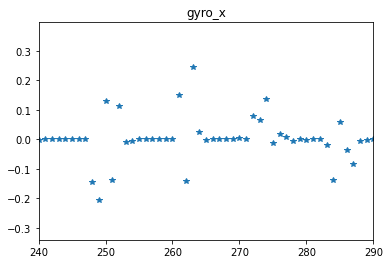

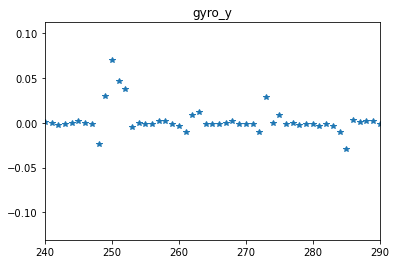

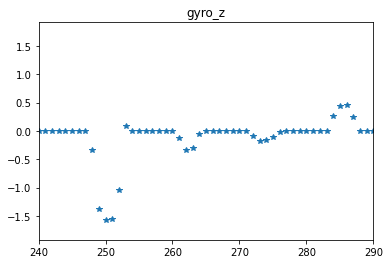

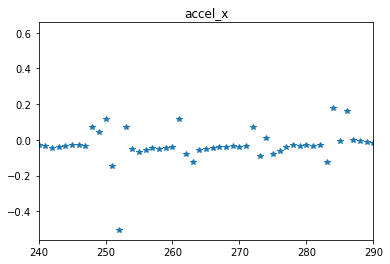

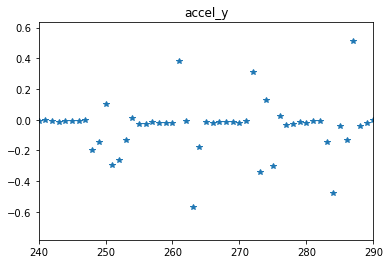

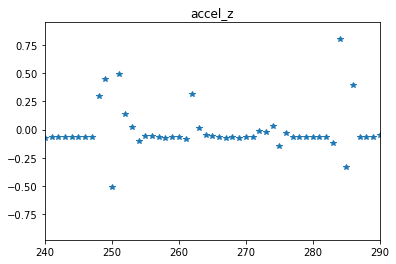

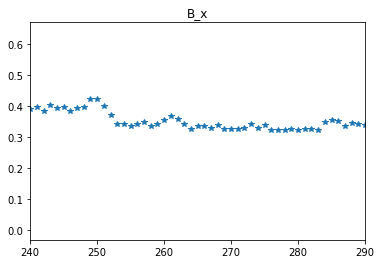

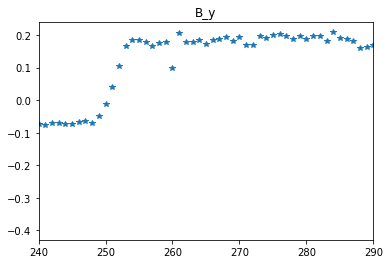

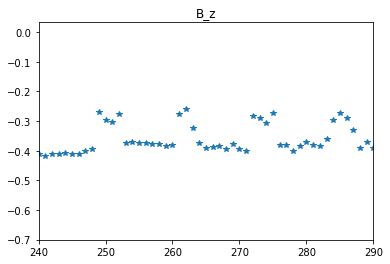

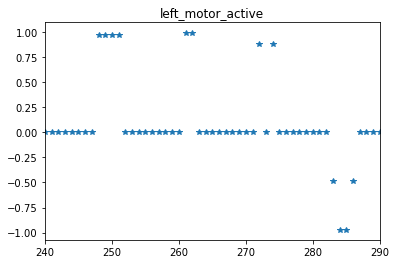

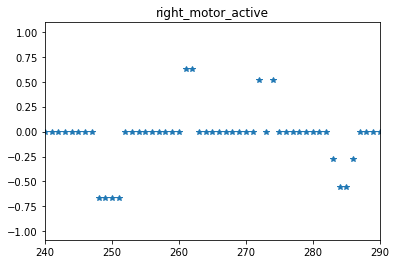

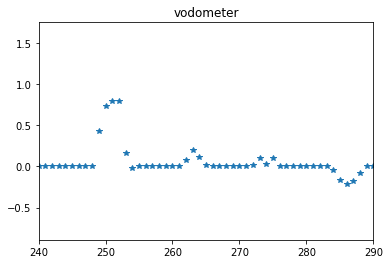

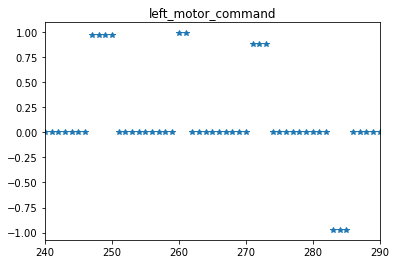

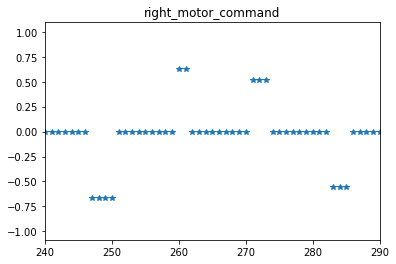

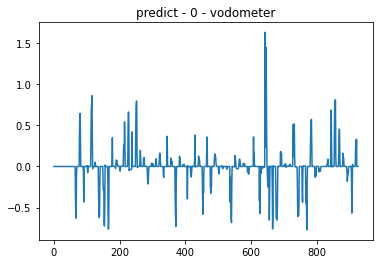

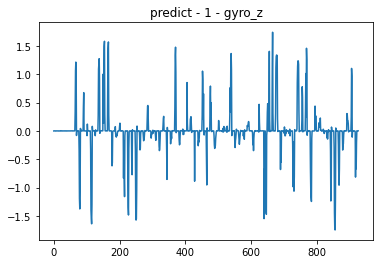

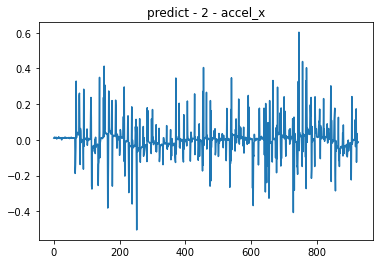

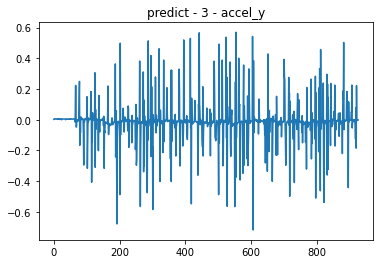

In [3]:
from matplotlib import pyplot as plt


def plot_state_vectors(state_vectors,command_vectors,predict_vectors):
    for i in range(state_vectors.shape[-1]):
        fig, ax = plt.subplots()
        plt.title(state_names[i])
        plt.xlim(240,290)
        ax.plot(state_vectors[:,i],'*')
        plt.show()
    for i in range(predict_vectors.shape[-1]):
        fig, ax = plt.subplots()
        plt.title("predict - {} - {}".format(i,state_names[state_to_predict_mapping[i]]))
        ax.plot(predict_vectors[:,i])
        plt.show()
        
plot_state_vectors(state_vectors,command_vectors,predict_vectors)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm import tqdm

class SimulatorLSTM(nn.Module):
    def __init__(self,input_size,output_size,hidden_size):
        #input size is features_size+control_size
        #output_size is features_size
        super(SimulatorLSTM, self).__init__()        
        self.input_size=input_size
        self.output_hidden_size=output_size
        self.output_size=output_size
        self.hidden_size=hidden_size
        self.lstm=nn.LSTM(input_size,hidden_size,batch_first=True) #number of hidden nodes same as input
        self.combiner=nn.Sequential(nn.Linear(input_size+hidden_size,output_size),
                                    nn.Tanh(),
                                    nn.Linear(output_size,output_size))
        
    def multi_prediction(self,input_x_array_batched,hc_start):
        #input_x_array_batched, a concatenated array of (state,control) of shape [n_batch,n_seq,features_size+control_size]
        hidden_array_batched,last_hcout_array_batched=self.lstm(input_x_array_batched,hc_start)        
        input_and_hidden_merged_batched=torch.cat((input_x_array_batched,hidden_array_batched),2)
        prediction_batched=self.combiner(input_and_hidden_merged_batched)
        return prediction_batched,last_hcout_array_batched        
        
    def single_prediction(self,state_x,control_x,hc ):
        #inputs
        # state_x -> vector indicating system state
        # control_x -> vector indicating control input
        # hc ->   (hidden_state, c_from_lstm)
        input_x_array_batched=torch.unsqueeze(torch.unsqueeze(torch.cat(state_x,control_x),0),0) # turn it into [batch, sequence, value]
        hc_array_batched=torch.unsqueeze(torch.unsqueeze(hc))        
        prediction_batched,last_hcout_array_batched=self.multi_prediction(input_x_array,hc_array_batched)
        return prediction_batched[0][0],last_hcout_array_batched[0][0]
    
    def forward(self,x,hc_start=None):
        return self.multi_prediction(x,hc_start)
    
class SimulatorLSTMMulti(nn.Module):
    def __init__(self,encoder_input_size,decoder_input_size,output_size,hidden_size):
        #input size is features_size+control_size
        #output_size is features_size
        super(SimulatorLSTMMulti, self).__init__()        
        self.input_size=encoder_input_size                        
        #self.output_hidden_size=output_size
        #self.output_size=output_size
        #self.hidden_size=hidden_size
        #encoder decoder here        
        self.encoder=nn.LSTM(encoder_input_size,hidden_size,batch_first=True)#order is [batch_no,sequence,feature]
        self.decoder=nn.LSTM(decoder_input_size,hidden_size,batch_first=True)        
        #print("decoder input size {}".format(decoder_input_size))
        #predictor here        
        self.predictor=nn.Sequential(nn.Linear(hidden_size,output_size),
                                     nn.Tanh(),
                                     nn.Linear(output_size,output_size))
        
    def multi_prediction(self,encoder_inputs,decoder_inputs,hc_start=None):
        #encode visible inputs into hiddens
        hidden_array,last_hcout_array=self.encoder(encoder_inputs,hc_start)
        # last_hcout_array is a (h,c) with h (1,batch_no,h_no)
        #print("last_hcout_array[0] shape {}".format(last_hcout_array[0].shape))
        #print("decoder inputs shape {}".format(decoder_inputs.shape))
        #decode         
        #hidden_array,last_hcout_array=self.decoder(decoder_inputs,last_hcout_array)
        hidden_array,last_hcout_array=self.decoder(decoder_inputs,None)
        #turn hidden array into features, it has [batch_no,sequence_no,h_no]
        prediction=self.predictor(hidden_array)
        return prediction,hidden_array
    
    def forward(self,x,hc_start=None):
        return self.multi_prediction(x[0],x[1],hc_start)        

In [5]:
#device = torch.device('cuda') 
device = torch.device('cpu') 

#model=SimulatorLSTM(14,14,10).to(device)
model=SimulatorLSTMMulti(state_vector_length,command_vector_length,predict_vector_length,predict_vector_length+command_vector_length)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

#a = next(iter(train_dataloader))
#print(a[2])


def train_model_step(model,optimizer,state_batch,command_batch,result_batch):    
    loss_function = torch.nn.MSELoss()
    out,_=model( (state_batch,command_batch) )
    loss=loss_function(out,result_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def test_model_step(model,state_batch,command_batch,result_batch):    
    loss_function = torch.nn.MSELoss()
    out,_=model( (state_batch,command_batch))
    loss=loss_function(out,result_batch)
    return loss.item()
    

def train_simulator(model,train_dataloader,test_dataloader):
    # Loop over epochs
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_loss_log=[]
    test_loss_log=[]
    max_epochs=2000
    for epoch in tqdm(range(max_epochs)):
        # Training
        train_loss_sum=0
        counter=0
        for state_batch, command_batch, result_batch in train_dataloader:
            #print("state batch shape {}".format(state_batch.shape))
            #print("command batch shape {}".format(command_batch.shape))
            #print("predict batch shape {}".format(result_batch.shape))
            # Transfer to GPU
            state_batch, command_batch, result_batch=state_batch.to(device), command_batch.to(device), result_batch.to(device)                                                
            train_loss_sum+=train_model_step(model,optimizer,state_batch,command_batch,result_batch)
            counter+=1
        train_loss_log.append(train_loss_sum/counter)
    
        test_loss_sum=0
        counter=0
        with torch.set_grad_enabled(False):
            for state_batch, command_batch, result_batch in test_dataloader:            
                # Transfer to GPU                
                state_batch, command_batch, result_batch=state_batch.to(device), command_batch.to(device), result_batch.to(device)                                                                
                test_loss_sum+=test_model_step(model,state_batch,command_batch,result_batch)
                counter+=1
        test_loss_log.append(test_loss_sum/counter)
    return train_loss_log,test_loss_log
    
train_loss_log,test_loss_log=train_simulator(model,train_dataloader,test_dataloader)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:41<00:00, 19.69it/s]


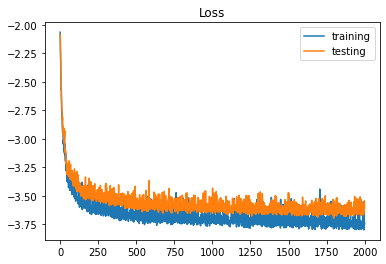

In [6]:
fig, ax = plt.subplots()
plt.title("Loss")
ax.plot(np.log(train_loss_log),label="training")
ax.plot(np.log(test_loss_log),label="testing")
plt.legend()
plt.show()

0
[12, 13]


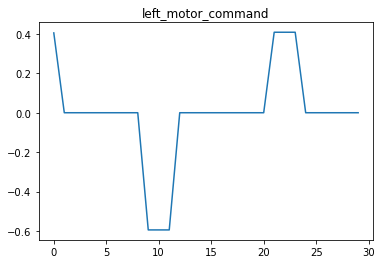

1
[12, 13]


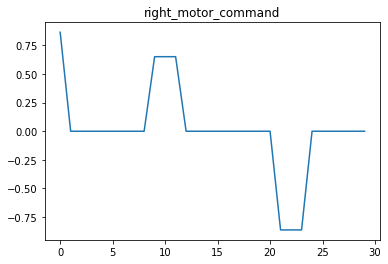

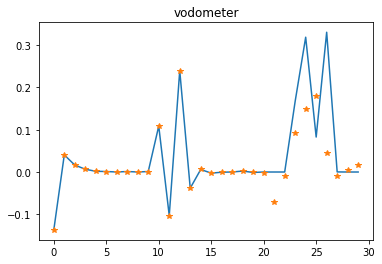

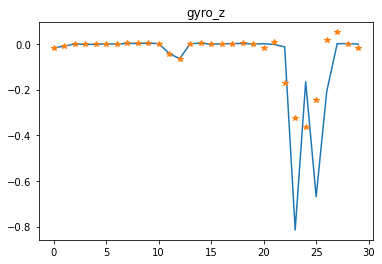

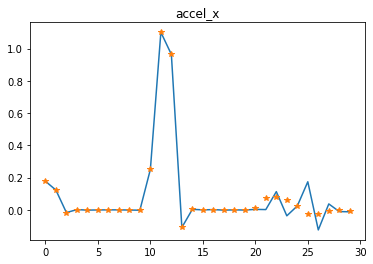

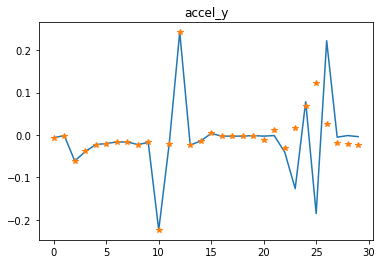

0
[12, 13]


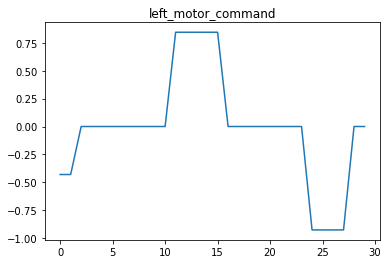

1
[12, 13]


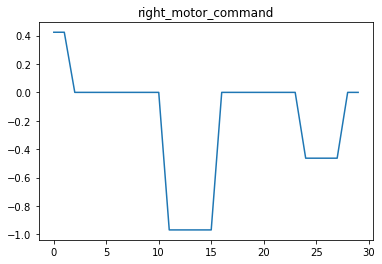

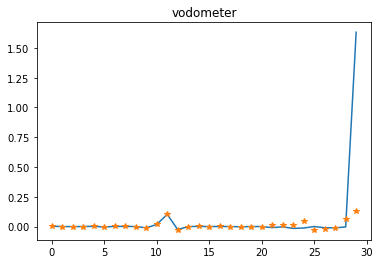

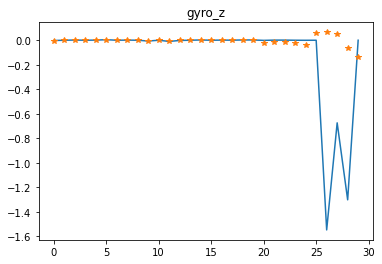

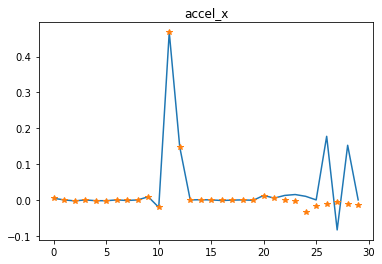

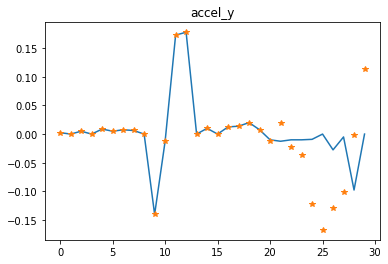

0
[12, 13]


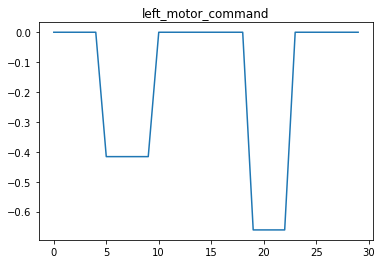

1
[12, 13]


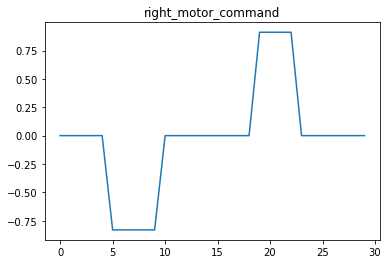

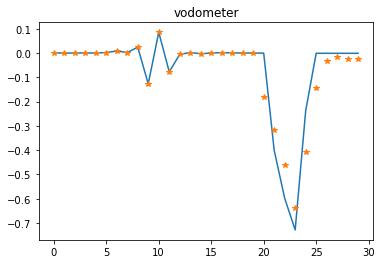

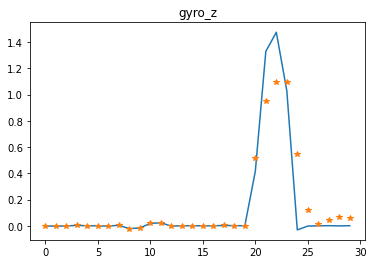

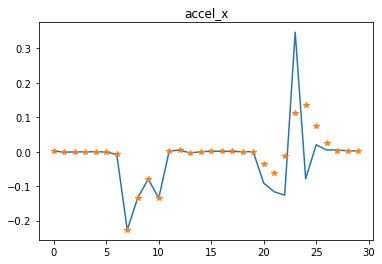

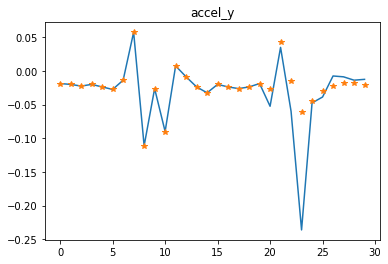

0
[12, 13]


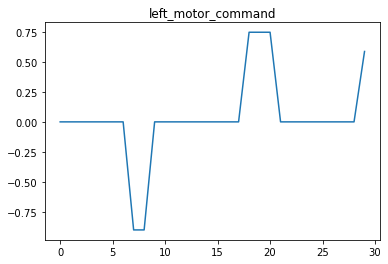

1
[12, 13]


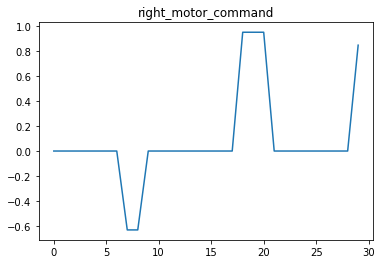

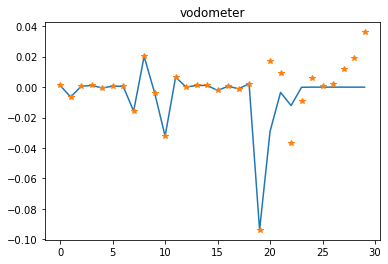

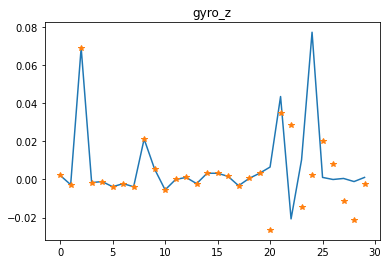

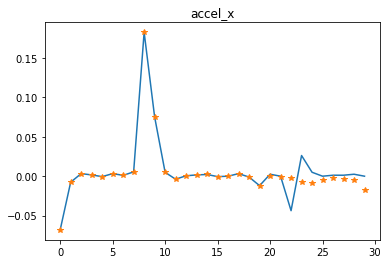

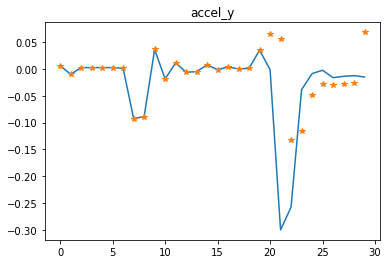

In [7]:
def plot_examples(on_batch=0):
    state_batch, command_batch, result_batch=next(iter(test_dataloader))
    out,_=model( (state_batch,command_batch))    
    for i in range(command_batch.shape[-1]):
        print(i)
        print(state_to_command_mapping)
        real_dat=np.zeros( out.shape[1]+state_batch.shape[1] )
        real_dat[0:state_batch.shape[1]]=state_batch[on_batch,:,state_to_command_mapping[i]].detach().numpy()
        real_dat[state_batch.shape[1]:]=command_batch[on_batch,:,i]
        fig, ax = plt.subplots()
        plt.title(state_names[state_to_command_mapping[i]])
        #plt.title(state_names[i])
        ax.plot(real_dat)

        #ax.plot(my_dat,'*')
        #ax.plot(out[0,:,i].detach().numpy())
        
        plt.show()
        
        
        
    for i in range(out.shape[-1]):
        real_dat=np.zeros( out.shape[1]+state_batch.shape[1] )
        real_dat[0:state_batch.shape[1]]=state_batch[on_batch,:,i].detach().numpy()
        real_dat[state_batch.shape[1]:]=result_batch[on_batch,:,i].detach().numpy()
        my_dat=np.zeros( out.shape[1]+state_batch.shape[1] )
        my_dat[0:state_batch.shape[1]]=state_batch[on_batch,:,i].detach().numpy()
        my_dat[state_batch.shape[1]:]=out[on_batch,:,i].detach().numpy()
        fig, ax = plt.subplots()
        plt.title(state_names[state_to_predict_mapping[i]])
        #plt.title(state_names[i])
        ax.plot(real_dat)

        ax.plot(my_dat,'*')
        #ax.plot(out[0,:,i].detach().numpy())
        
        plt.show()
        
plot_examples(0)
plot_examples(1)
plot_examples(2)
plot_examples(3)
        

lr ?/? total odometer prediction 0.5716203451156616
lr ?/? total odometer prediction 1.0813789367675781
lr ?/? total odometer prediction 0.6994156241416931
lr ?/? total odometer prediction -0.7856735587120056
lr ?/? total odometer prediction -1.2991389036178589
lr ?/? total odometer prediction 0.297450989484787
lr ?/? total odometer prediction 0.7277610301971436
lr ?/? total odometer prediction 0.22369158267974854
lr ?/? total odometer prediction -0.8628129363059998
lr ?/? total odometer prediction -1.1819796562194824
lr ?/? total odometer prediction 0.1533643752336502
lr ?/? total odometer prediction 0.5483210682868958
lr ?/? total odometer prediction 0.12607358396053314
lr ?/? total odometer prediction -0.4920831620693207
lr ?/? total odometer prediction -0.7125468850135803
lr ?/? total odometer prediction 0.3999949097633362
lr ?/? total odometer prediction 0.8305469751358032
lr ?/? total odometer prediction 0.6019365787506104
lr ?/? total odometer prediction 0.13404279947280884
lr ?

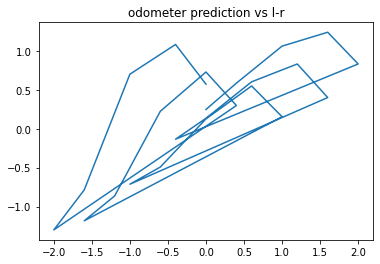

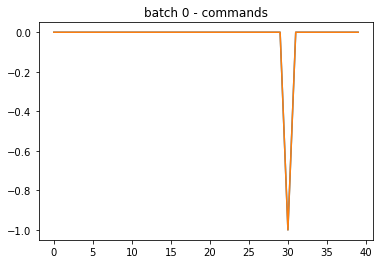

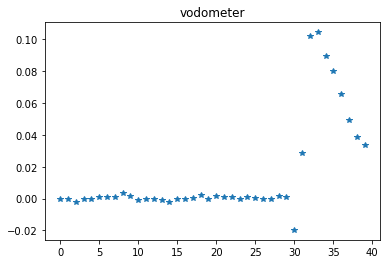

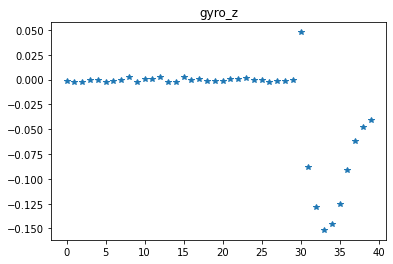

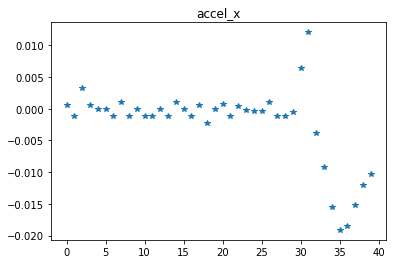

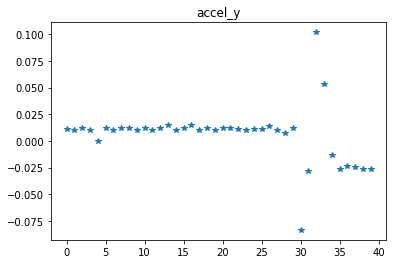

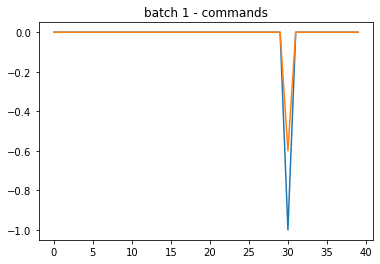

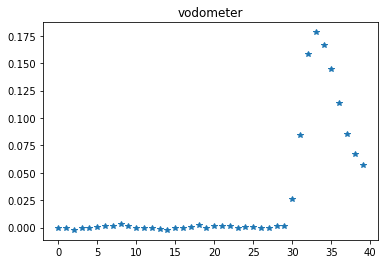

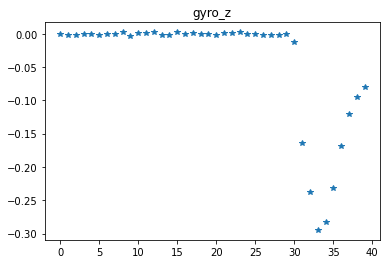

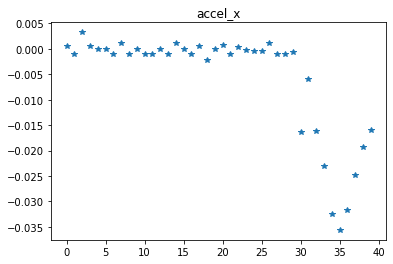

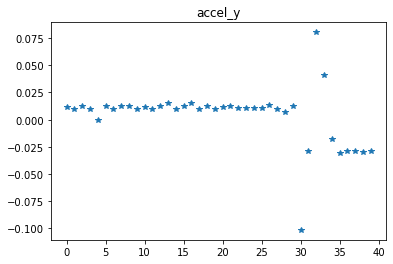

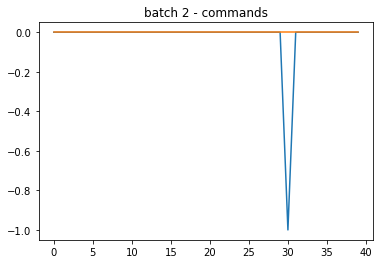

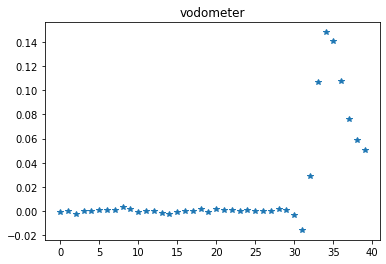

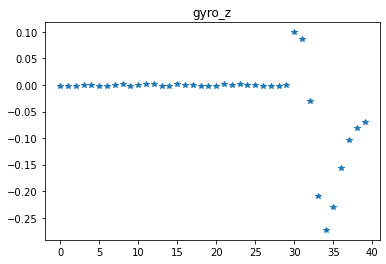

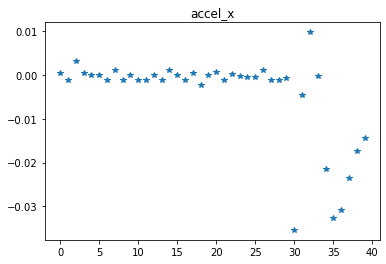

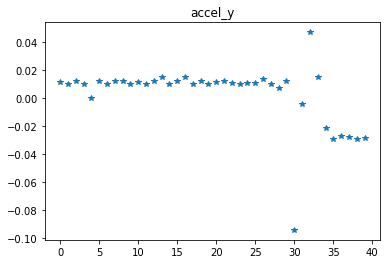

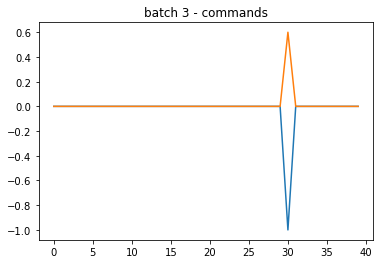

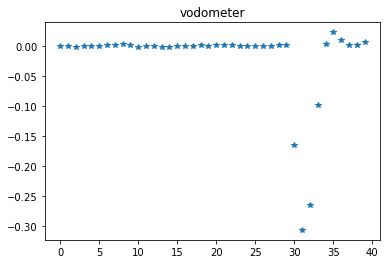

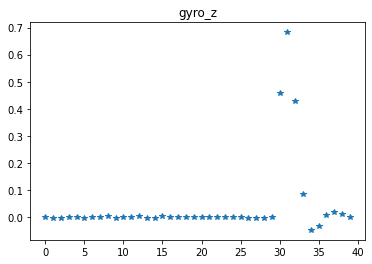

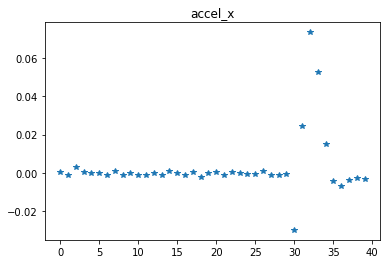

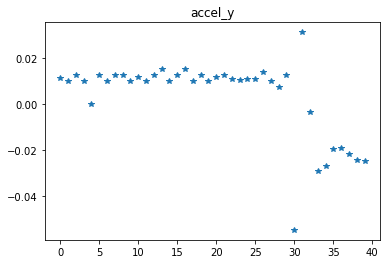

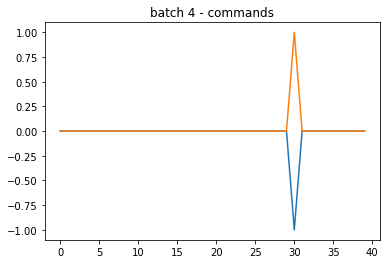

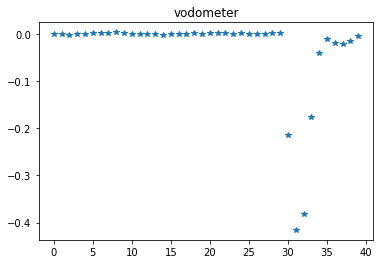

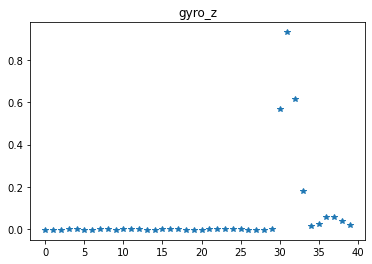

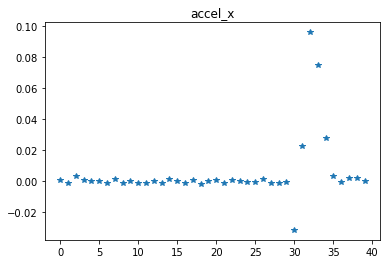

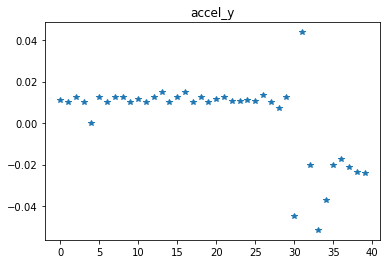

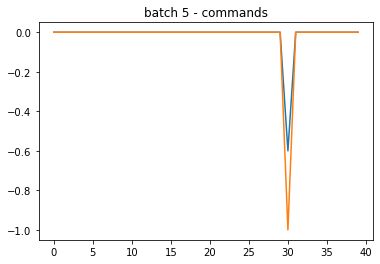

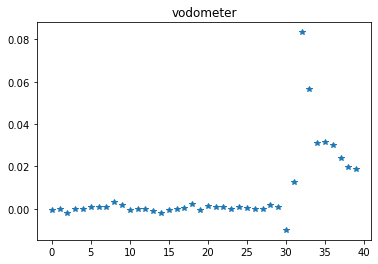

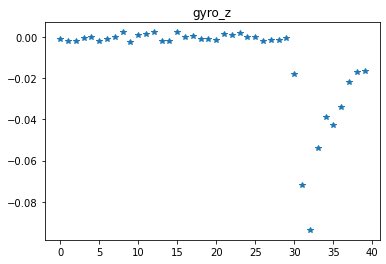

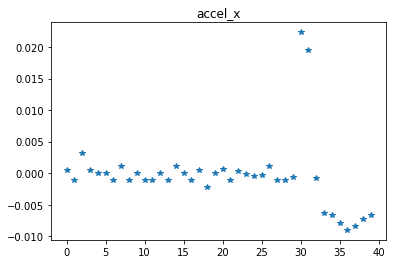

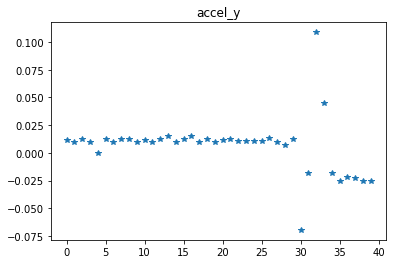

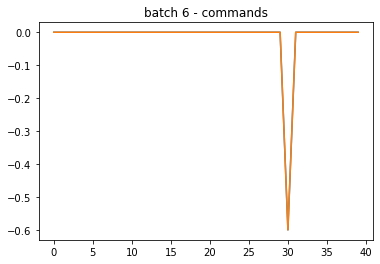

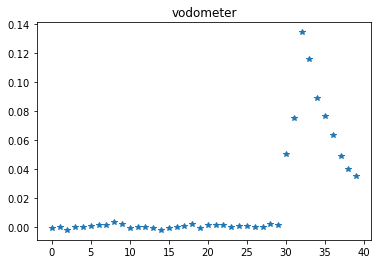

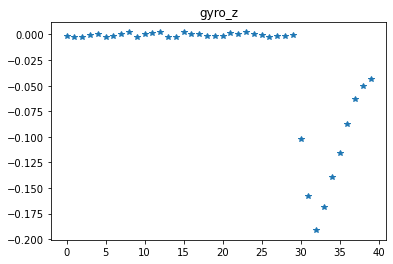

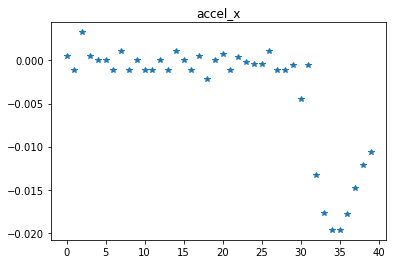

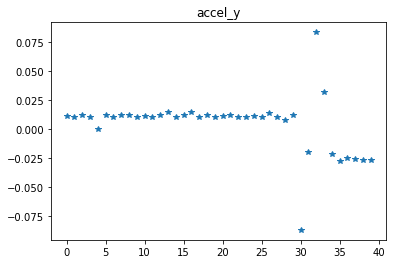

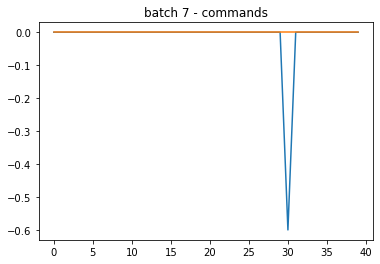

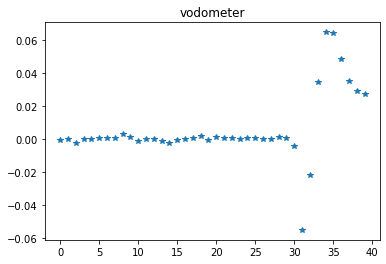

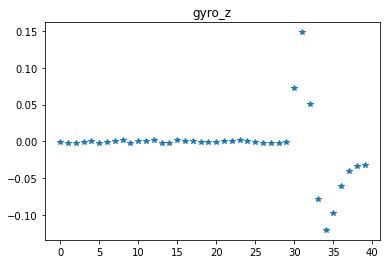

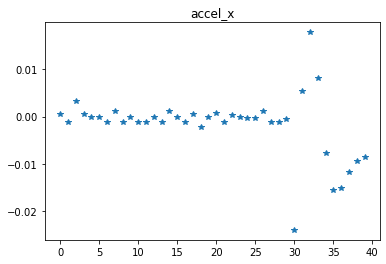

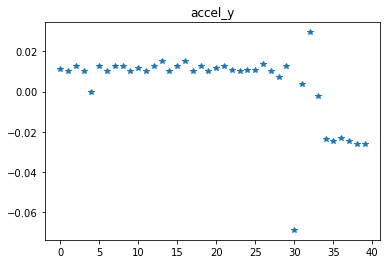

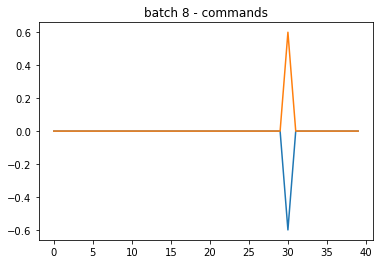

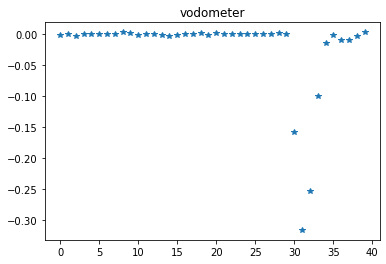

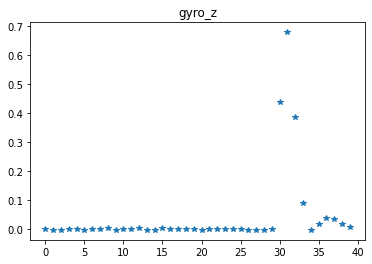

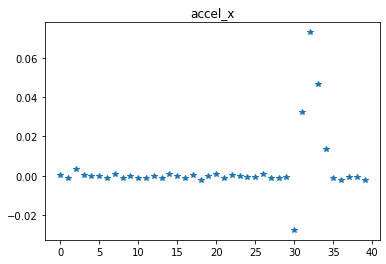

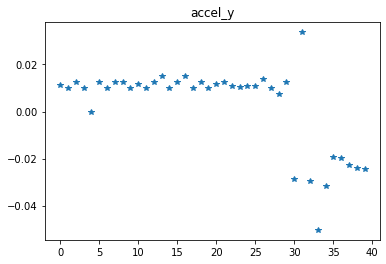

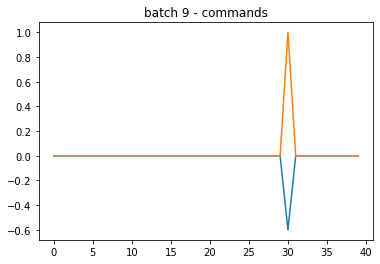

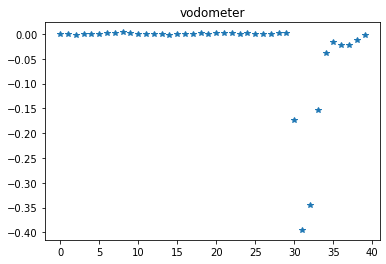

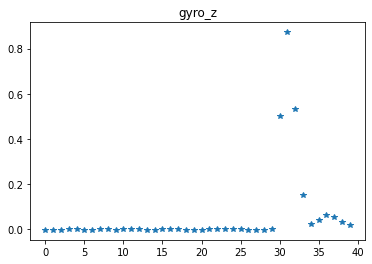

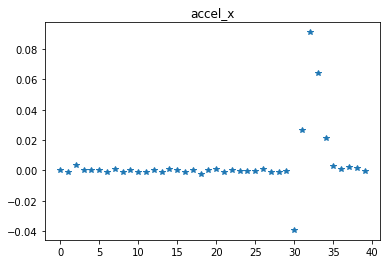

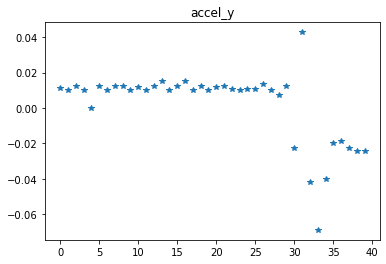

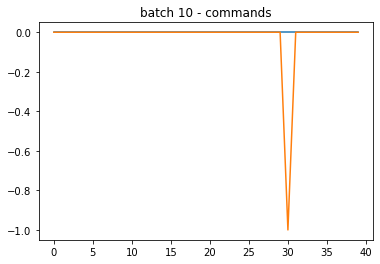

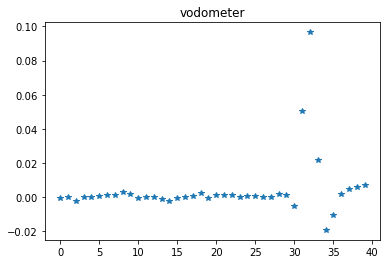

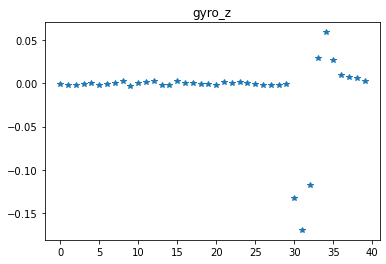

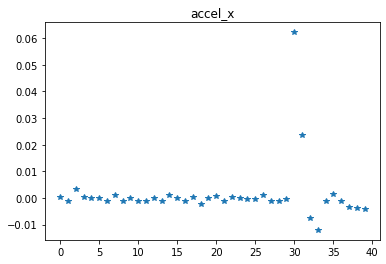

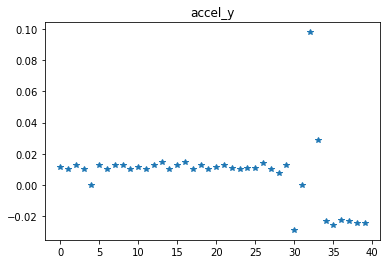

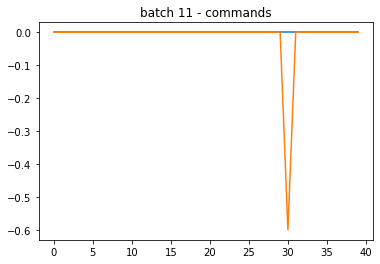

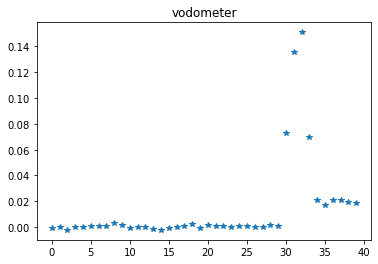

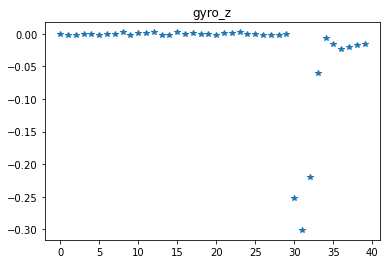

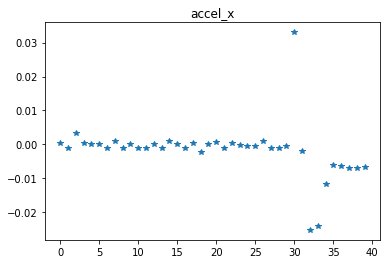

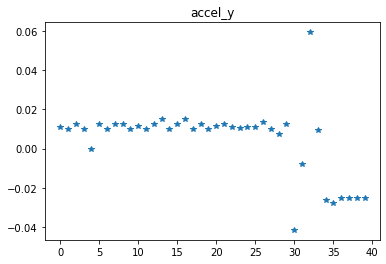

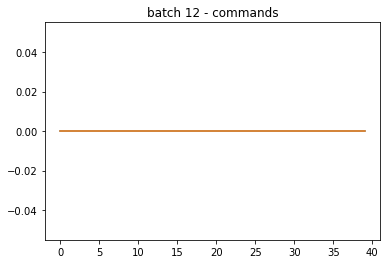

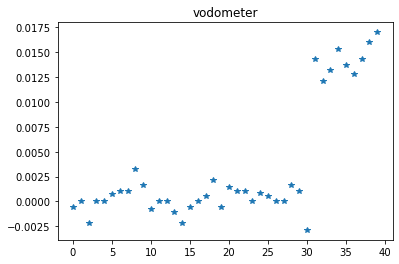

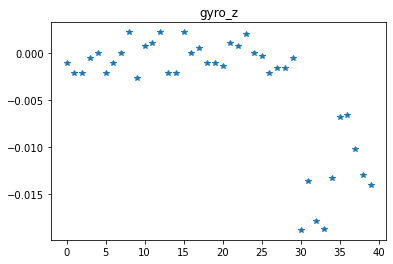

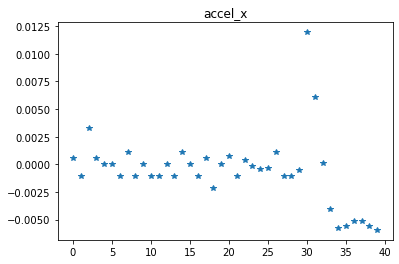

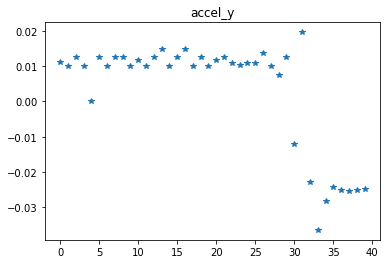

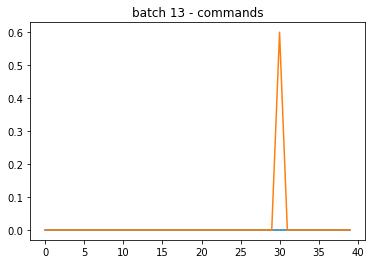

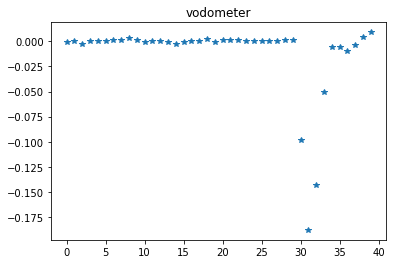

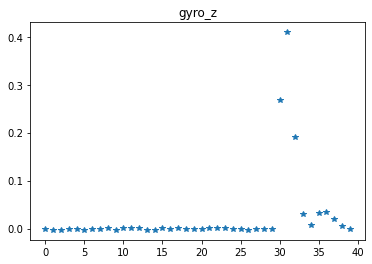

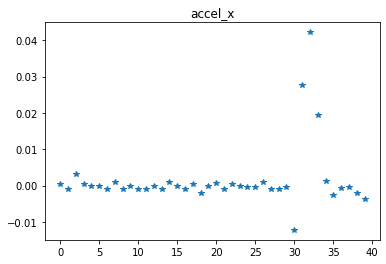

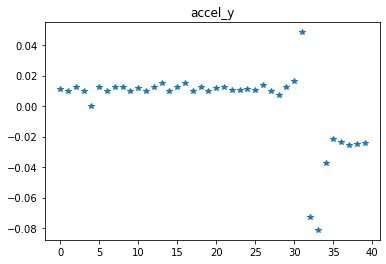

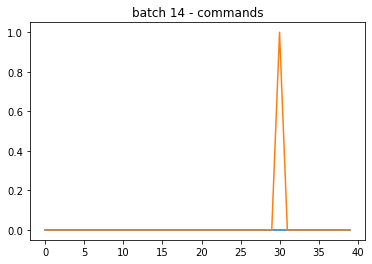

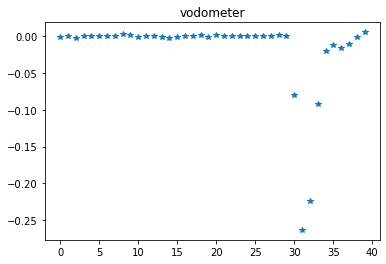

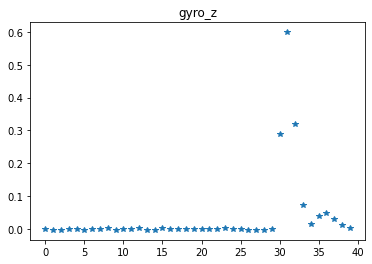

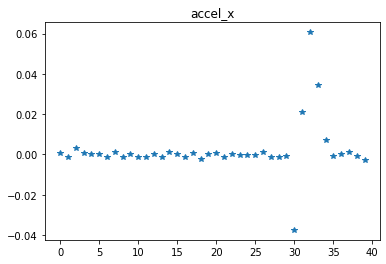

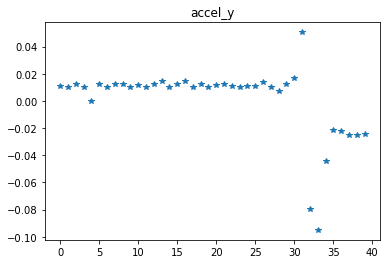

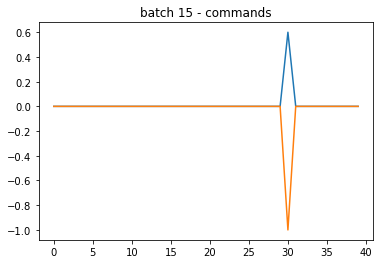

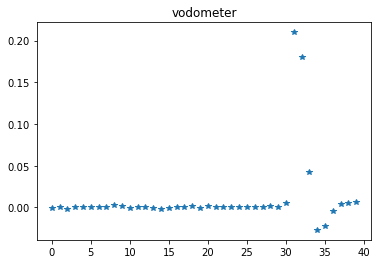

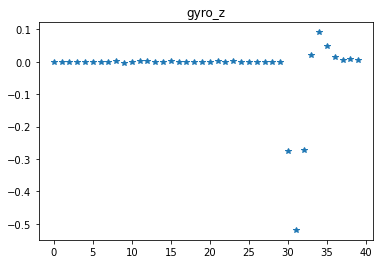

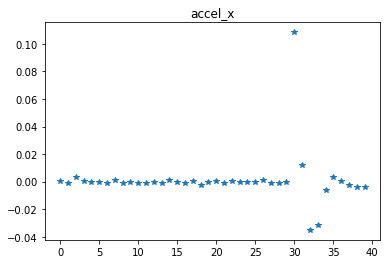

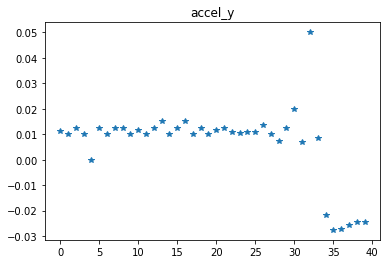

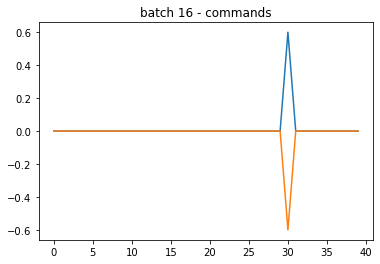

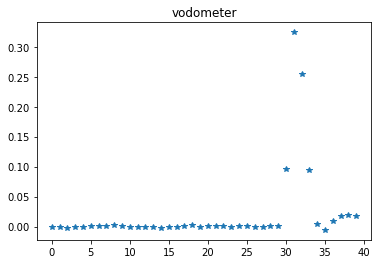

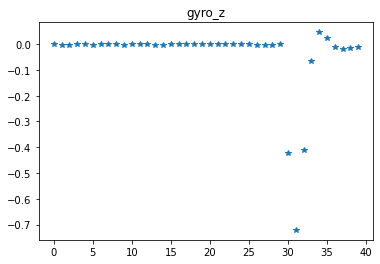

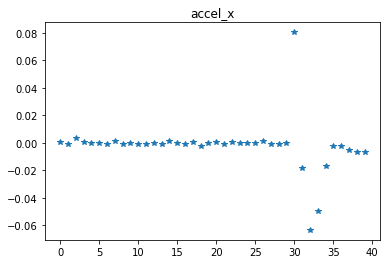

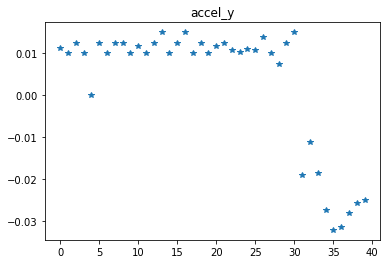

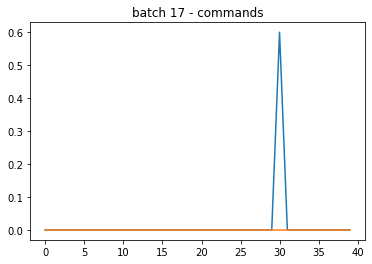

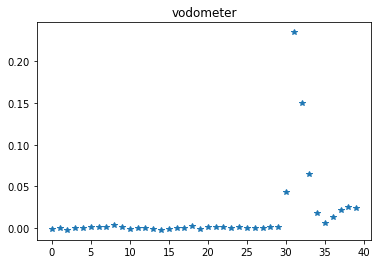

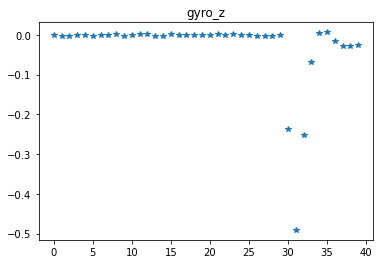

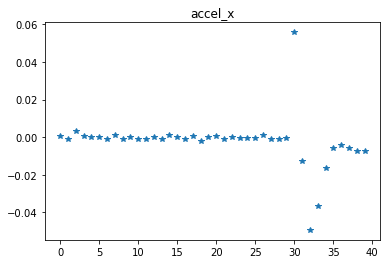

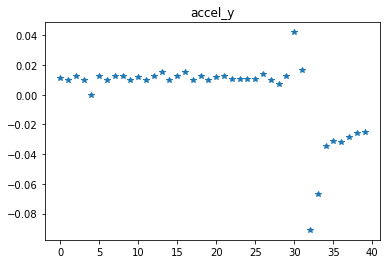

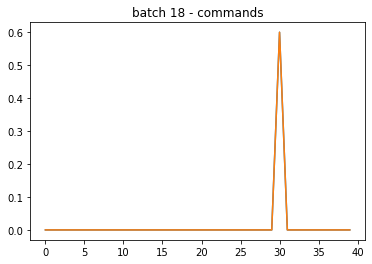

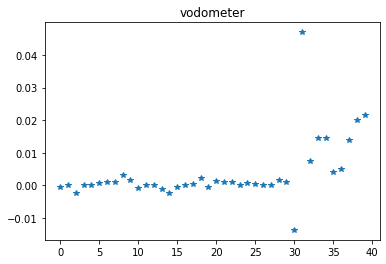

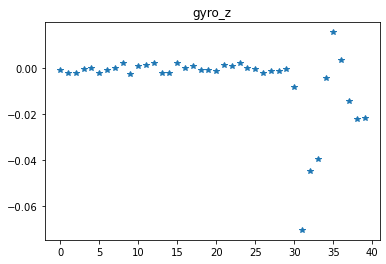

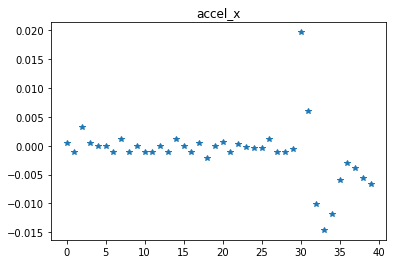

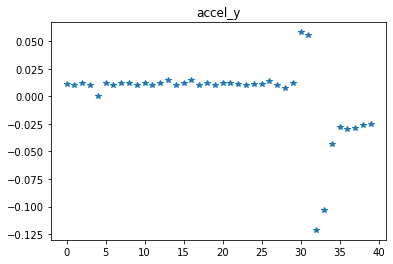

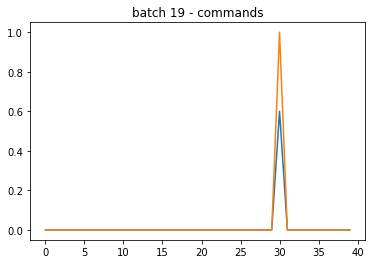

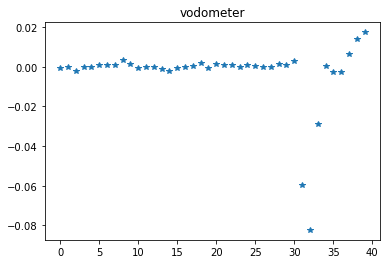

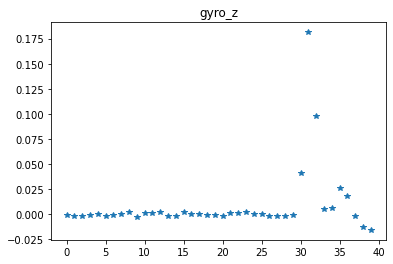

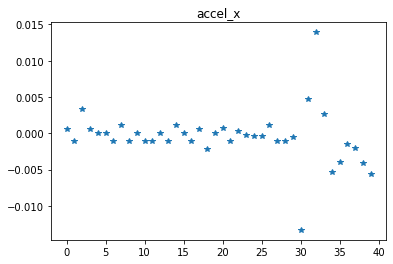

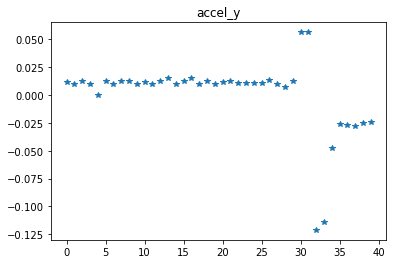

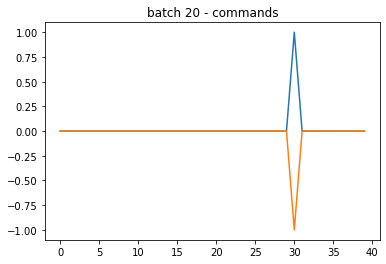

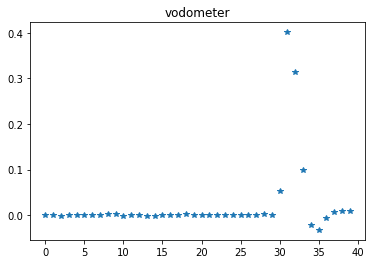

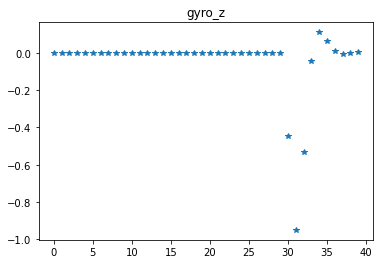

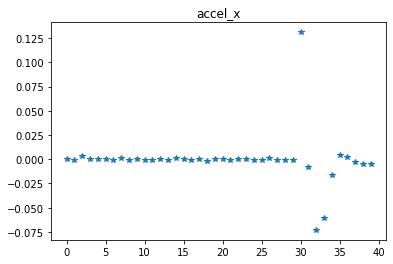

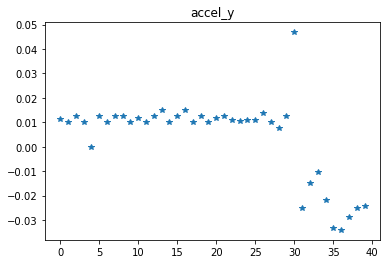

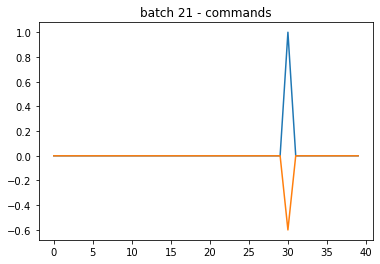

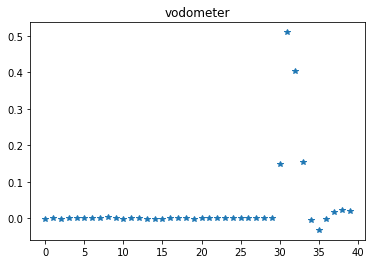

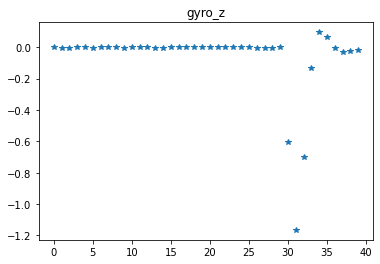

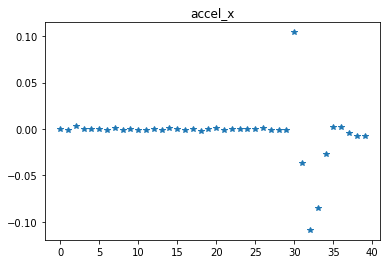

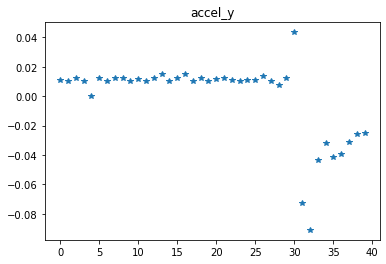

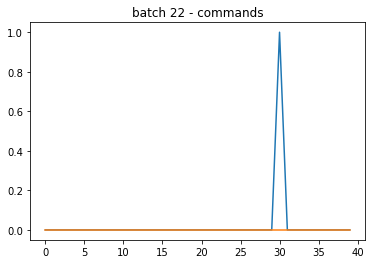

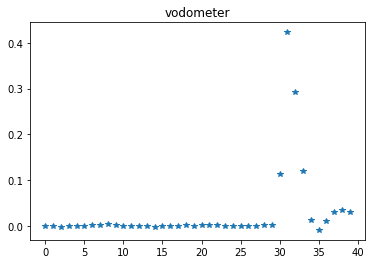

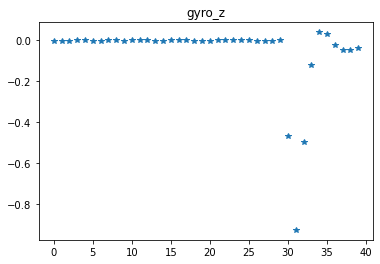

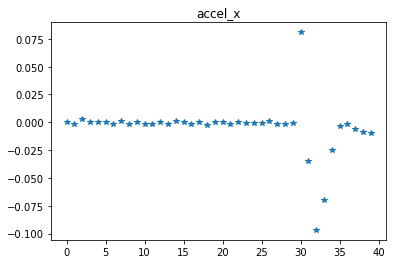

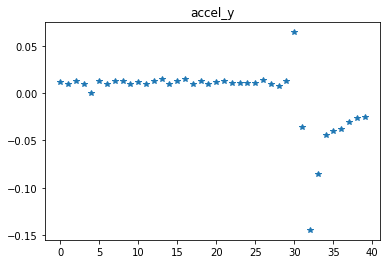

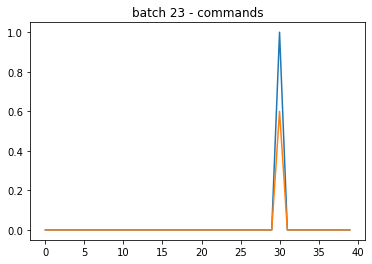

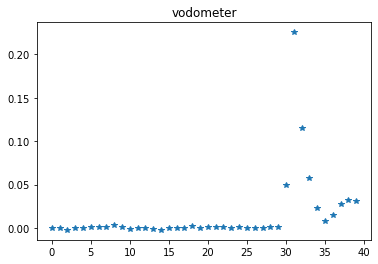

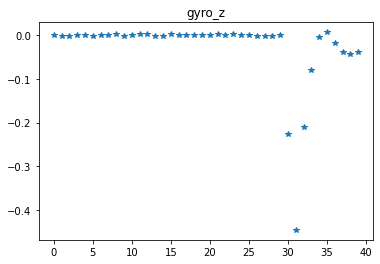

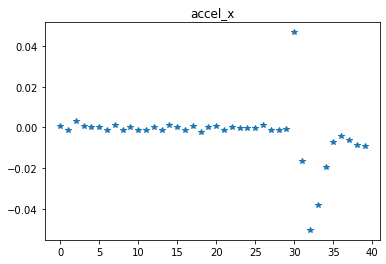

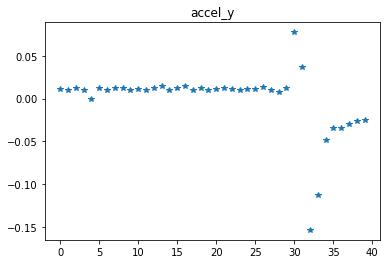

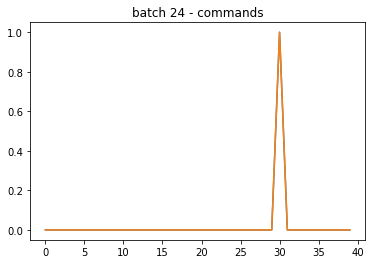

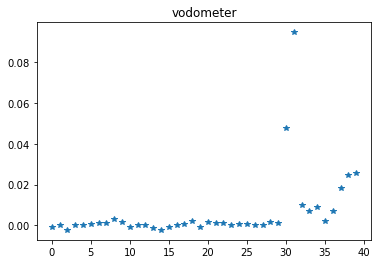

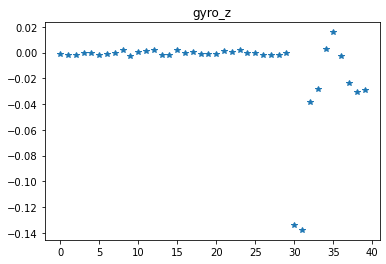

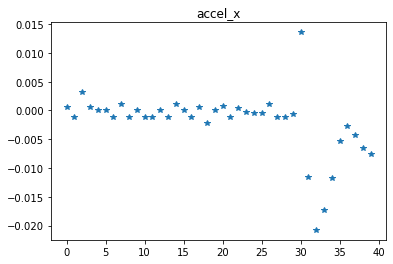

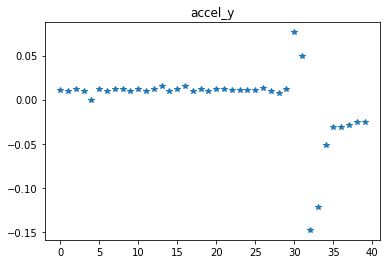

In [9]:
#now try some tests
#get queiscent data from run beginning

quiet_state=state_vectors[20:50]

def build_test_state(lmotor,rmotor):
    command_vec=torch.zeros([10,2])
    command_vec[0,0]=lmotor
    command_vec[0,1]=rmotor
    return command_vec
    
svecs=[]
cvecs=[]
lr_rec=[]
for l in [-1.0,-0.6,0,0.6,1.0]:
    for r in [-1.0,-0.6,0,0.6,1.0]:
        cvecs.append(build_test_state(l,r))
        svecs.append(quiet_state)
        lr_rec.append(l-r)
        
states=torch.stack(svecs)
commands=torch.stack(cvecs)

out,_=model( (states,commands))    

odo_counter=[]
for on_batch in range(out.shape[0]):        
    tot_odo=np.sum(out[on_batch,:,0].detach().numpy())
    print("lr {}/{} total odometer prediction {}".format("?","?",tot_odo))
    odo_counter.append(tot_odo)
    
fig, ax = plt.subplots()
plt.title("odometer prediction vs l-r")
plt.plot(lr_rec,odo_counter)
plt.show()

for on_batch in range(out.shape[0]):        
    real_dat=np.zeros( [out.shape[1]+states.shape[1],2] )
    real_dat[0:states.shape[1],0]=states[on_batch,:,state_to_command_mapping[0]].detach().numpy()
    real_dat[0:states.shape[1],1]=states[on_batch,:,state_to_command_mapping[1]].detach().numpy()
    real_dat[states.shape[1]:,0]=commands[on_batch,:,0]
    real_dat[states.shape[1]:,1]=commands[on_batch,:,1]
    fig, ax = plt.subplots()
    plt.title("batch {} - {}".format(on_batch,"commands"))    
    ax.plot(real_dat)                
    plt.show()
    
    for i in range(out.shape[-1]):       
        my_dat=np.zeros( out.shape[1]+states.shape[1] )
        my_dat[0:states.shape[1]]=states[on_batch,:,i].detach().numpy()
        my_dat[states.shape[1]:]=out[on_batch,:,i].detach().numpy()
        fig, ax = plt.subplots()
        plt.title(state_names[state_to_predict_mapping[i]])
        #plt.title(state_names[i])
        #ax.plot(real_dat)

        ax.plot(my_dat,'*')
        #ax.plot(out[0,:,i].detach().numpy())
        
        plt.show()
    
        

    


